# Analysis of $Mo_{1-x}Re_xS_2$ simulations

**Extract statistically significant information about effective interactions between Mo and Re atoms**

**Notebook setup**

In [1]:
%matplotlib inline

import os
import sys
import copy
import pickle
from collections import Counter
from itertools import product, combinations
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.stats import norm, chi2
from scipy.optimize import fmin

from subprocess import Popen, PIPE
import multiprocessing as mp

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../src/utils')
from utils import *

In [4]:
path_raw = '../data/raw'
path_tmp = "../data/tmp"

## 1. Images

Extract Mo and Re positions for each image

In [5]:
def get_simulation_results(data_dir, names):

    atom_pos = [] 
    atom_ids = []

    for name in names:
        npy_name = os.path.join(data_dir, name +'_sim2.npy')
        mat = np.load(npy_name)
        atom_pos.append(mat[:, 100:])
        atom_ids.append(mat[:, 0:100])

    return atom_pos, atom_ids

In [6]:
# select relevant atomic coordinates for further analysis
# different files store different atoms in centroids_1 and centroids_2 -> sort this out
names = ['re05', 're55', 're78', 're95'] # hdf5 file name roots

In [7]:
atom_pos, atom_ids_sim = get_simulation_results(path_tmp, names)

In [8]:
atom_ids = [[aids[:, i] for aids in atom_ids_sim] for i in range(100)]

## Examples from conditional simulations

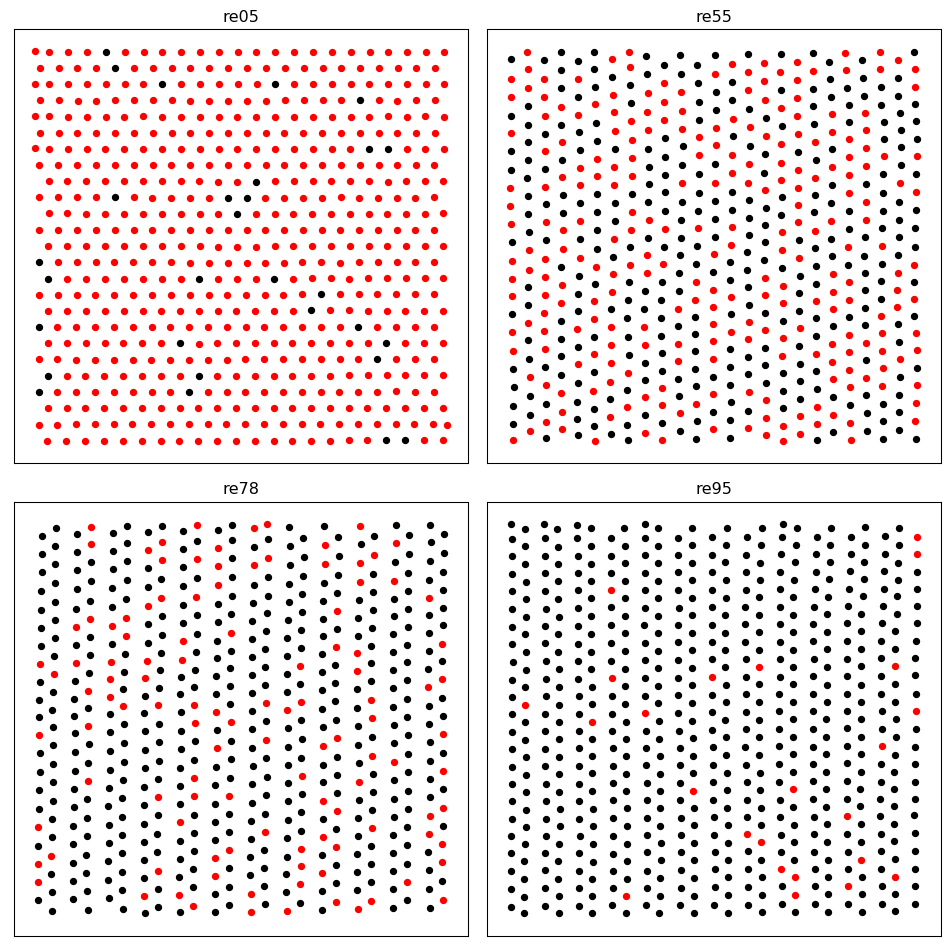

In [10]:
show_positions(names, atom_pos, atom_ids_sim, symbol_size = 20, isim = 59)

In [11]:
# Separate atoms to Mo and Re based on image-specific intensity threshold
intensity_thresh = [0.80, 0.45, 0.45, 0.45]  # intensity thresholds for each image
atom_pos_orig, atom_ids_orig, intensities = get_atom_positions(path_raw, names, intensity_thresh)
#show_images(names, atom_pos_orig, atom_ids_orig, intensities)

### Identify distinct local configurations and collect target histograms

In [12]:
distance_thresh = [45, 32, 30, 26]  # distance thresholds for each image

In [13]:
target_hist, num_samples = collect_target_histograms(names, atom_pos, atom_ids_orig, distance_thresh)

cfg_types = sorted(set([c for h in target_hist.values() for c in h]))

# symmetry number for each configuration
conf_counts, conf_dict, trans_hist = config_symmetry_numbers(cfg_types)

#trans_hist = make_transform_matrix(cfg_types, conf_dict)

# probability of each symmetrized configuration for a given Re concentration
x_re = rhenium_concentration(target_hist)

# random - null hypothesis
prob_conf = random_config_proba(names, conf_counts, x_re)

## Configuration statistics of correlated samples from conditional simulations

In [15]:
probs = {'re05': [], 're55': [], 're78': [], 're95': []}
for i in range(100):
    #print("iter:", i)
    target_hist, num_samples = collect_target_histograms(names, atom_pos, atom_ids[i], distance_thresh)
    cfg_types = sorted(set([c for h in target_hist.values() for c in h]))
    cfg_labels = [str(c) for c in cfg_types]
    for name in names:
        all_counts = np.array([target_hist[name].get(cfg, 0) for cfg in cfg_types])
        all_counts = all_counts/float(num_samples[name])
        probs[name].append(all_counts)

In [16]:
fp = open(os.path.join(path_tmp, "probs.pickle"), mode = "wb")
pickle.dump(probs, fp)
fp.close()

In [17]:
#fn = open(os.path.join(path_tmp, "probs.pickle"), mode = "rb")
#xx = pickle.load(fn)
#fn.close()
#probs = xx

In [18]:
# Relative frequencies, their means and standard deviations
proba = { k:np.stack(probs[k]) for k in probs }
p_mean = { k:np.mean(proba[k], axis = 0) for k in proba}
p_std = { k:np.std(proba[k], axis = 0) for k in proba}

In [19]:
# Show random and simulation histograms with errorbars
def plot_bar_stats(names, p_mean, p_std, prob_conf, cfg_types):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14), dpi = 96)

    cfg_labels = [str(c) for c in cfg_types]
    for i, name in enumerate(names):
        p_array = [(k, v) for k, v in prob_conf[name].items()]
        all_counts_p = np.array([prob_conf[name].get(cfg, 0) for cfg in cfg_types])

        nconf = len(cfg_labels)
        width = 0.4

        ir, ic = divmod(i, 2)
        axs[ir, ic].bar(np.arange(nconf)+0.2, all_counts_p, width, color='r', label='random', yerr = all_counts_p/nconf)
        axs[ir, ic].bar(np.arange(nconf)-0.2, p_mean[name], width, color='b', label='sim', yerr = p_std[name])

        axs[ir, ic].legend()
        axs[ir, ic].set_xticks(range(nconf))
        axs[ir, ic].set_xticklabels(cfg_labels, rotation=90.0, fontsize=16)
        #axs[ir, ic].set_title('Image: ' + name + '\nActual Re concentration: ' + str(x_re[name]))#', Total number of samples: n = ' + str(n_sample))
        axs[ir, ic].set_ylabel(r'$\sqrt{p}$', fontsize=20)

        plt.tight_layout()

    plt.show()

## Histograms with error bars - random vs. correlated samples

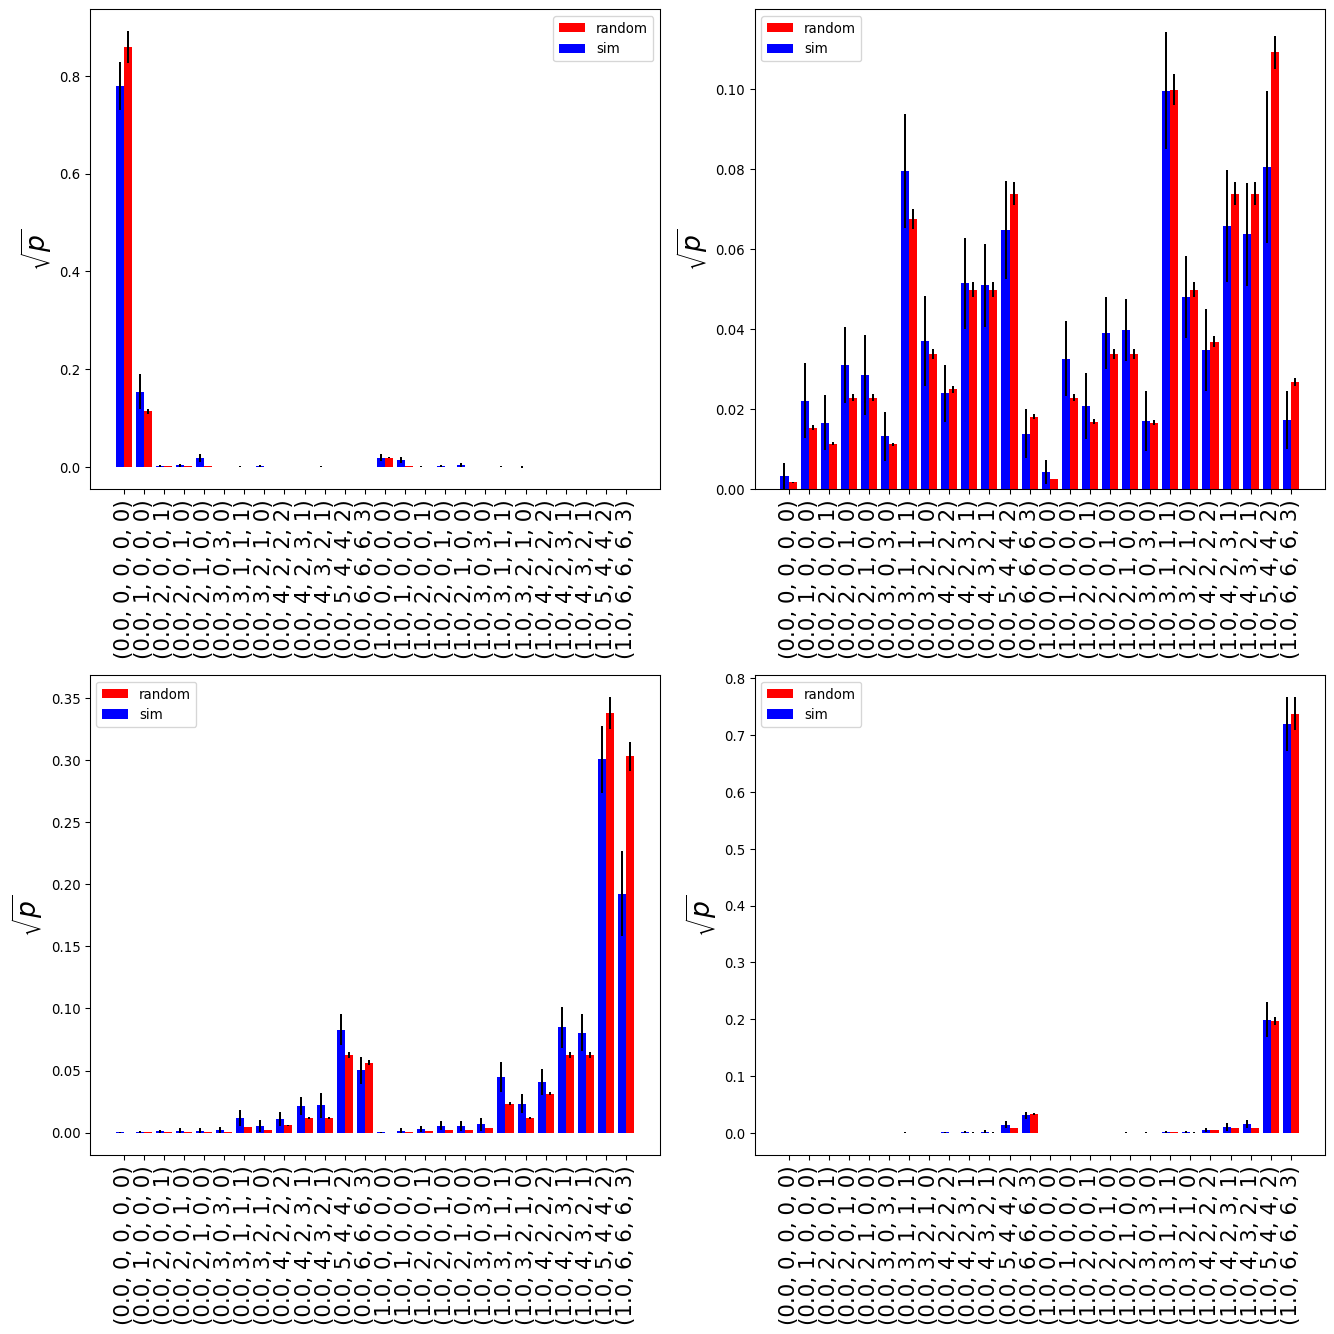

In [20]:
plot_bar_stats(names, p_mean, p_std, prob_conf, cfg_types)

## Standard deviation around mean in the probability space

In [21]:
# Average statistical distance of correlated samples from the mean distribution
sdist = { nam:np.mean(np.arccos(np.sum((proba[nam]*p_mean[nam])**0.5, axis = 1))) for nam in names}
sdist

{'re05': 0.12352664088161608,
 're55': 0.13833213440898454,
 're78': 0.14816904786166818,
 're95': 0.1099174393190345}

In [22]:
# Draws for multinomial probabilty
# Average statistical distance of uncorrelated samples from the mean distribution
prand = {}
mrand = {}
for nam in names:
    p_array = [(k, v) for k, v in prob_conf[nam].items()]
    prand[nam] = np.array([prob_conf[nam].get(cfg, 0) for cfg in cfg_types])
    mrand[nam] = np.random.multinomial(num_samples[nam], prand[nam], 100)/num_samples[nam]

In [23]:
rdist = { nam:np.mean(np.arccos(np.sum((prand[nam]*mrand[nam])**0.5, axis = 1))) for nam in names}
rdist

{'re05': 0.06971640493646201,
 're55': 0.12246070200833621,
 're78': 0.12326310130143352,
 're95': 0.07979295192652244}

In [24]:
# Fraction of standard deviations for correlated and uncorrelated samples
nfrac = { nam: (rdist[nam]/sdist[nam])**2 for nam in names }

## Original statistical distances

In [25]:
s2r = {'re05': 0.0062, 're55': 0.0325, 're78': 0.0298, 're95': 0.0124}
s2p1 = {'re05': 0.0067, 're55': 0.0283, 're78': 0.0263, 're95': 0.0129}
s2p2 = {'re05': 0.0070, 're55': 0.0288, 're78': 0.0247, 're95': 0.0121}
s2m = {'re05': 0.0073, 're55': 0.0284, 're78': 0.0275, 're95': 0.0121}

num_samples, nfrac

({'re05': 464, 're55': 466, 're78': 434, 're95': 471},
 {'re05': 0.3185287991509398,
  're55': 0.7836954646552647,
  're78': 0.6920718753138719,
  're95': 0.5269820946469516})

### Adjusted p-values

In [26]:
# Random averages, but correlated
pr = { nam:(1 - chi2.cdf(4*num_samples[nam]*s2r[nam]*nfrac[nam], 25)) for nam in names}
pr

{'re05': 0.9999997900095627,
 're55': 0.004306470699649512,
 're78': 0.07464551206017678,
 're95': 0.9838797252011421}

In [27]:
# Pair, NN
pp1 = { nam:(1 - chi2.cdf(4*num_samples[nam]*s2p1[nam]*nfrac[nam], 25)) for nam in names}
pp1

{'re05': 0.9999995164394992,
 're55': 0.021132266898001628,
 're78': 0.16998168773298328,
 're95': 0.9787736433359379}

In [28]:
# Pair, NNN
pp2 = { nam:(1 - chi2.cdf(4*num_samples[nam]*s2p2[nam]*nfrac[nam], 25)) for nam in names}
pp2

{'re05': 0.9999992291043461,
 're55': 0.017658354946163413,
 're78': 0.23667004149969928,
 're95': 0.9864604898344635}

In [29]:
# Manybody
pm = { nam:(1 - chi2.cdf(4*num_samples[nam]*s2m[nam]*nfrac[nam], 25)) for nam in names}
pm

{'re05': 0.9999987988961028,
 're55': 0.02039133921795222,
 're78': 0.130083216769607,
 're95': 0.9864604898344635}